In [103]:
import numpy as np
import pandas as pd

import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


pd.options.display.float_format = "{:.2f}".format
df = pd.read_csv('Data/weatherAUS.csv')

df.Date=pd.to_datetime(df.Date).dt.date
# df.insert(0, 'Year', pd.DatetimeIndex(df['Date']).year)
df.insert(0, 'Month', pd.DatetimeIndex(df['Date']).month)
df=df.drop(columns='Date')

In [104]:
df.isna().sum()

Month                0
Location             0
MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustDir       9330
WindGustSpeed     9270
WindDir9am       10013
WindDir3pm        3778
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
RainToday         1406
RISK_MM              0
RainTomorrow         0
dtype: int64

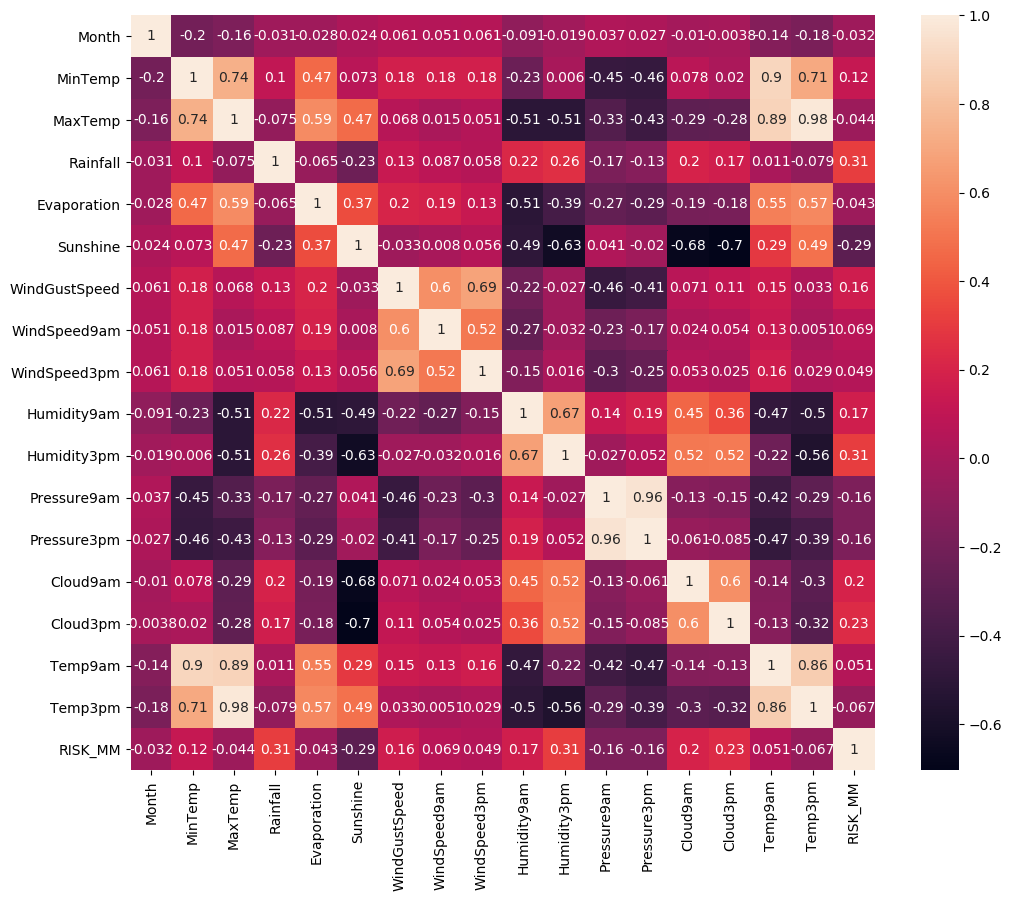

In [105]:
plt.figure(figsize=(12,10),dpi = 100)
sns.heatmap(df.corr(),annot = df.corr())

In [106]:
df = df.drop(columns=['RISK_MM'])

In [107]:
def split(df,proportion):
    x_train, x_test, y_train, y_test = train_test_split(
        df.iloc[:,0:-1],df.iloc[:,-1].astype('category').cat.codes, test_size=proportion)#, random_state=0)
    return {"x_train":x_train, "x_test":x_test, "y_train":y_train, "y_test":y_test}

splitted_data = split(df,0.3)

columns_categ = [col for col in df.columns if df[col].dtypes == 'O']
columns_categ.remove('RainTomorrow')
columns_numeric = [col for col in df.columns if df[col].dtypes != 'O']


In [114]:
ave = splitted_data['x_train'].groupby([splitted_data['x_train']['Location'],
                                        splitted_data['x_train']['Month']]).median()
ave.loc['Adelaide'].iloc[1][0]

17.0

In [96]:
def fill_month_numeric(atr):
    splitted_data = df.groupby(by=[df.Location, df.Month]).transform(lambda x: x.fillna(x.median()))

def fill_month_categ(atr):
    df[atr] = df.groupby(by=[df.Location, df.Month]).transform(lambda x: x.fillna(x.mode()))

    
for atr in columns_categ:
    fill_month_categ(atr)
    
for atr in columns_numeric:
    fill_month_numeric(atr)

# for col in columns_numeric:
#     col_median=splitted_data['x_train'][col].median()
#     splitted_data['x_train'][col].fillna(col_median, inplace=True)   


# for col in columns_numeric:
#     col_median=splitted_data['x_test'][col].median()
#     splitted_data['x_test'][col].fillna(col_median, inplace=True)  
    
    
# for col in columns_categ:
#     col_mode=splitted_data['x_train'][col].mode()[0]
#     splitted_data['x_train'][col].fillna(col_mode, inplace=True)   


# for col in columns_categ:
#     col_mode=splitted_data['x_test'][col].mode()[0]
#     splitted_data['x_test'][col].fillna(col_mode, inplace=True)  
    
splitted_data['x_train']

KeyError: 'Location'

In [88]:

for col in columns_numeric:
    col_median=splitted_data['x_train'][col].median()
    splitted_data['x_train'][col].fillna(col_median, inplace=True)   


for col in columns_numeric:
    col_median=splitted_data['x_test'][col].median()
    splitted_data['x_test'][col].fillna(col_median, inplace=True)  
    
    
for col in columns_categ:
    col_mode=splitted_data['x_train'][col].mode()[0]
    splitted_data['x_train'][col].fillna(col_mode, inplace=True)   


for col in columns_categ:
    col_mode=splitted_data['x_test'][col].mode()[0]
    splitted_data['x_test'][col].fillna(col_mode, inplace=True)  
    
splitted_data['x_train']


,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
116726,PerthAirport,14.40,18.70,8.20,5.80,2.50,E,56.00,SE,SSE,...,22.00,72.00,75.00,1015.50,1013.00,7.00,7.00,15.10,18.00,Yes
23694,Penrith,17.10,34.20,0.00,4.80,8.50,WNW,63.00,E,N,...,9.00,86.00,42.00,1017.60,1015.20,5.00,5.00,20.70,32.80,No
90265,GoldCoast,19.50,28.30,0.00,4.80,8.50,NNE,39.00,NNE,NNE,...,31.00,66.00,62.00,1016.70,1012.30,5.00,5.00,25.50,26.00,No
126141,Walpole,14.30,27.80,0.00,4.80,8.50,SE,37.00,ESE,SE,...,26.00,69.00,57.00,1017.00,1014.10,5.00,5.00,22.60,26.10,No
118224,Perth,12.50,25.60,0.00,7.80,12.60,SW,31.00,SSW,SW,...,17.00,57.00,38.00,1015.40,1013.20,0.00,0.00,20.90,24.60,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12127,Moree,12.90,22.00,12.80,6.60,6.50,SW,31.00,NW,WSW,...,20.00,92.00,48.00,1016.10,1014.20,8.00,4.00,15.40,21.00,Yes
101457,Nuriootpa,9.20,14.80,6.60,6.00,0.30,NW,54.00,N,NW,...,31.00,96.00,92.00,1008.90,1004.40,8.00,8.00,10.10,13.00,Yes
59077,Bendigo,-1.90,14.40,0.20,4.80,8.50,W,26.00,SW,NNW,...,11.00,76.00,45.00,1021.20,1017.70,8.00,5.00,6.60,14.10,No
21994,NorfolkIsland,14.30,20.20,7.00,6.00,9.60,E,57.00,ESE,ESE,...,33.00,68.00,55.00,1019.50,1019.60,6.00,2.00,18.00,18.60,Yes


In [89]:
# def fill_month_numeric(atr):
#     df[atr] = df.groupby(by=[df.Location, df.Month]).transform(lambda x: x.fillna(x.median()))

# def fill_month_categ(atr):
#     df[atr] = df.groupby(by=[df.Location, df.Month]).transform(lambda x: x.fillna(x.mode()))
    


# for atr in columns_categ:
#     fill_month_categ(atr)
    
# for atr in columns_numeric:
#     fill_month_numeric(atr)

# crit_rate = 0.7
# arr_regions = []
# for region in df.Location.unique():
#     pand_reg = df[df.Location == region]
#     freq = pand_reg.count().divide(pand_reg.shape[0])
#     for i in range(len(freq)):
#         arr_drop = []
#         if freq[i] < crit_rate:
#             arr_drop.append(df.columns[i])
#         pand_reg = pand_reg.drop(arr_drop, axis=1)
#     arr_regions.append(pand_reg)

# df=df.drop(columns=["Temp9am", "Temp3pm", "Pressure9am", "RISK_MM",
#                     "Humidity9am", "Cloud9am", "MinTemp", "Rainfall", "Date"])

In [90]:
df=df.drop(columns='Month')
splitted_data['x_test'] = pd.concat([splitted_data['x_test'][columns_numeric],
                     pd.get_dummies(splitted_data['x_test'].Location), 
                     pd.get_dummies(splitted_data['x_test'].WindGustDir),
                     pd.get_dummies(splitted_data['x_test'].WindDir9am),
                     pd.get_dummies(splitted_data['x_test'].WindDir3pm)], axis=1)

splitted_data['x_train'] = pd.concat([splitted_data['x_train'][columns_numeric],
                     pd.get_dummies(splitted_data['x_train'].Location), 
                     pd.get_dummies(splitted_data['x_train'].WindGustDir),
                     pd.get_dummies(splitted_data['x_train'].WindDir9am),
                     pd.get_dummies(splitted_data['x_train'].WindDir3pm)], axis=1)


In [91]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(splitted_data['x_train'])
X_test = scaler.transform(splitted_data['x_test'])

splitted_data['x_train'] = pd.DataFrame(X_train, columns=[splitted_data['x_train'].columns])
splitted_data['x_test'] = pd.DataFrame(X_test, columns=[splitted_data['x_test'].columns])

In [92]:
splitted_data['x_train']

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
0,0.57,0.44,0.02,0.04,0.17,0.39,0.13,0.25,0.72,0.75,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
1,0.63,0.74,0.00,0.03,0.59,0.44,0.03,0.10,0.86,0.41,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.69,0.63,0.00,0.03,0.59,0.26,0.08,0.36,0.66,0.62,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.56,0.62,0.00,0.03,0.59,0.24,0.15,0.30,0.69,0.57,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.52,0.57,0.00,0.05,0.87,0.19,0.07,0.20,0.57,0.37,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99530,0.53,0.51,0.03,0.05,0.45,0.19,0.10,0.23,0.92,0.47,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
99531,0.44,0.37,0.02,0.04,0.02,0.37,0.08,0.36,0.96,0.92,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
99532,0.16,0.36,0.00,0.03,0.59,0.16,0.13,0.13,0.76,0.44,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
99533,0.56,0.47,0.02,0.04,0.66,0.40,0.23,0.38,0.68,0.55,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [93]:
# instantiate the model
logreg = LogisticRegression(solver='liblinear', random_state=0)

# fit the model
logreg.fit(splitted_data['x_train'], splitted_data['y_train'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [94]:
y_pred_test = logreg.predict(splitted_data['x_test'])

In [95]:
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(splitted_data['y_test'], y_pred_test)))

Model accuracy score: 0.8472
